# Lab 1: Linear Regression and Overfitting

In [3]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [1]:
# This cell makes sure that you have all the necessary libraries installed
import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

Install nb_conda with version 2.2.1 or newer


$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### Generate periodic data
First, a function is created to generate periodic data. The method has a parameter $N$ and returns $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$.

In [5]:
def gen_sine(n):
    # YOUR CODE HERE
    x = np.linspace(0, 2*np.pi, n)
    t = np.random.normal(np.sin(x), 0.25)

    return x, t


In [6]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [7]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    # YOUR CODE HERE
    Phi = np.array([[i**j for i in x] for j in range(M + 1)]).T
    
    return Phi

def fit_polynomial(x, t, M):
    # YOUR CODE HERE
    Phi = designmatrix(x, M)
    w_ml = np.dot(np.linalg.pinv(Phi), t)

    return w_ml, Phi


In [8]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

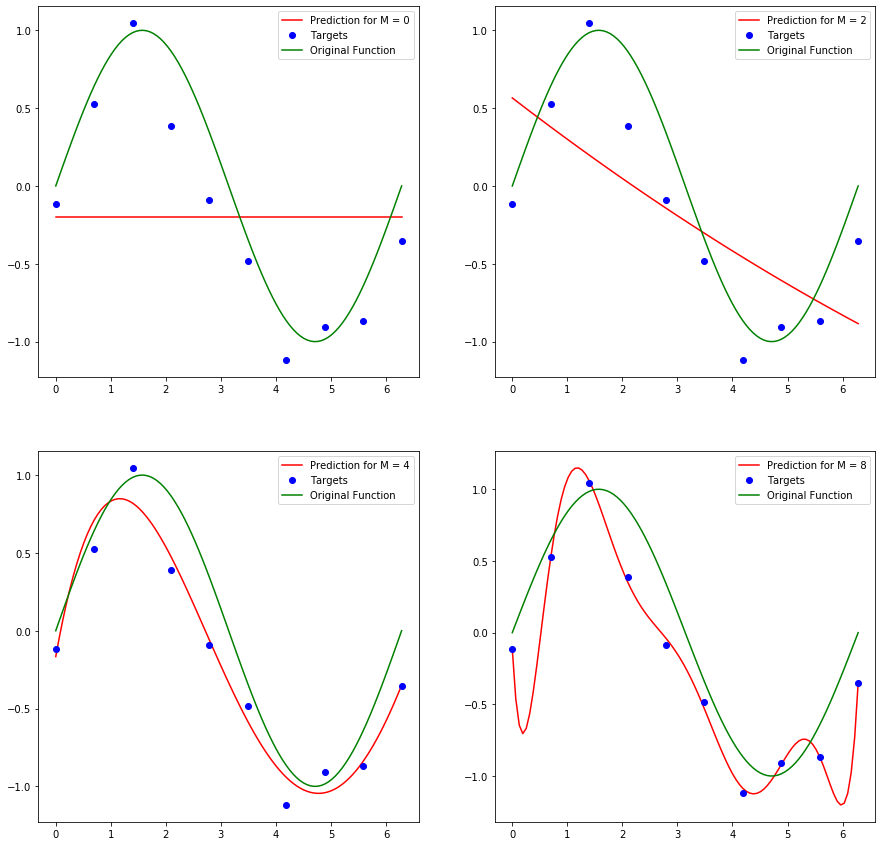

In [9]:
# YOUR CODE HERE
N = 10
plt.figure(figsize=[15, 15], edgecolor='black')
x, t = gen_sine(N)
k = 1

x_plot = np.linspace(0, 2*np.pi, 100)

for M in [0, 2, 4, 8]:
    w, Phi = fit_polynomial(x, t, M)
    plt.subplot(2, 2, k).set_label(('M = %d' % M))
    Phi = designmatrix(x_plot, M)
    plt.plot(x_plot, np.dot(w, Phi.T), '-r', label='Prediction for M = %d' % M)
    plt.plot(x, t, 'bo', label = 'Targets')
    plt.plot(x_plot, np.sin(x_plot), '-g', label="Original Function")
    plt.legend()
    k += 1



### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [16]:
def fit_polynomial_reg(x, t, m, lamb):
    phi = designmatrix(x, m)
    inverse_term = np.linalg.inv(lamb*np.identity(m+1) + np.dot(phi.T, phi))
    w_ml = np.dot(np.dot(inverse_term, phi.T), t)
    return w_ml, phi

#to compare outputs forr question 1.4b
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 50
w, _ = fit_polynomial(x, t, m)
w_reg, _ = fit_polynomial_reg(x,t,m, lamb)
print('weight without regularization: ',w, '\n', 'weight with regularization: ', w_reg)


weight without regularization:  [2.50000000e+00 9.99200722e-16 3.00000000e-01] 
 weight with regularization:  [ 4.25062143e-01 -2.08166817e-17  1.76357528e-01]


In [25]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

Phi doesn't change with regularization, but w does. Regularization causes the weights to become closer to zero (smaller in absolute value), as the last term of the error function penalizes higher weights. When lambda increases, this penalty becomes larger resulting in smaller absolute weights when minimizing the error function. When considering the test case, we set the lambda to 50 (extremely high to show a clear difference). As can be seen in the output of question 1.4a, all three weights decrease.






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [26]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    # YOUR CODE HERE
    w, _ = fit_polynomial_reg(x_train, t_train, M, reg)
    phi = designmatrix(x_valid, M)
    pw = np.dot(phi, w.T)
    pred_err = 0.5 * np.dot((pw - t_valid).T, pw - t_valid)

    return pred_err

In [27]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [28]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [29]:
def find_best_m_and_lamb(x, t):
    # YOUR CODE HERE
    N = len(t)
    k = 5
    M = [i for i in range(11)]
    lamb = [exp(i) for i in range(-10, 1)]
    best_err = 100
    
    for m in M:
        for l in lamb:
            error = 0
            train_folds, val_folds = kfold_indices(N, k)
            
            for train_fold, val_fold in zip(train_folds, val_folds):
                x_train, x_val, t_train, t_val = x[train_fold], x[val_fold], t[train_fold], t[val_fold]
                error += pred_error(x_train, x_val, t_train, t_val, m, l)
                
            error /= k
            
            if error < best_err: 
                best_err = error
                M_best, lamb_best = m, l
                
    return M_best, lamb_best

In [30]:
### This is not an empty cell (You don't need to care about it).


### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

The resulting parameter combinations do not span the entire range of possibilities: they only tell us something useful about the 2 parameter values we fixed, not about the 8 others. Therefore, this method is unlikely to obtain a good estimate.


For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

One alternative is random search, which chooses random values for all parameters [1]. In our example, if we only did 20 experiments out of the 100 possible, the randomness ensures the resulting parameter combinations span the entire possible range. In this way it can provide reasonable estimate with much greater efficiency.

[1] https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

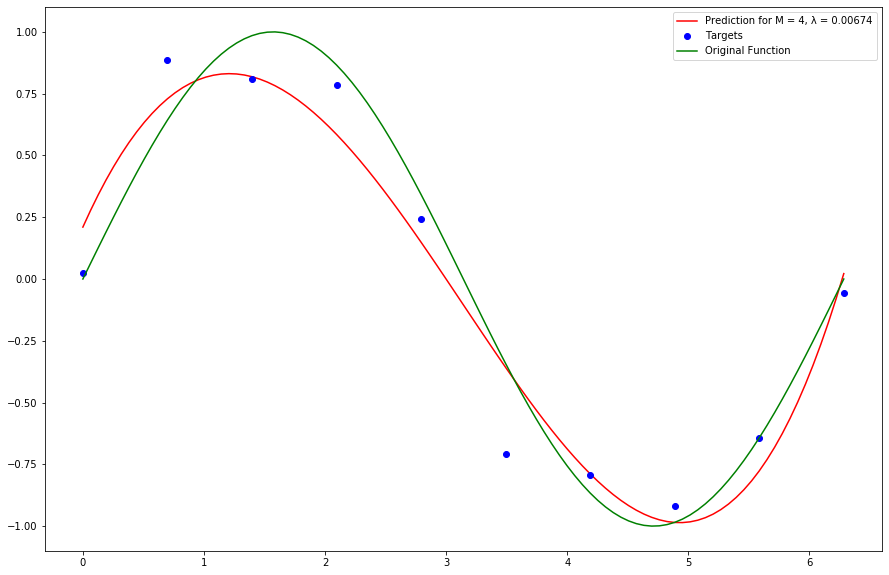

In [31]:
# YOUR CODE HERE
N = 10
x, t = gen_sine(N)
m, lamb = find_best_m_and_lamb(x, t)

w, _ = fit_polynomial_reg(x, t, m, reg)
x_plot = np.linspace(0, 2*np.pi, 100)
Phi = designmatrix(x_plot, m)

plt.figure(figsize=(15, 10), edgecolor='black')
plt.plot(x_plot, np.dot(w, Phi.T), '-r', label='Prediction for M = %d, λ = %.5f' % (m, lamb))
plt.plot(x, t, 'bo', label = 'Targets')
plt.plot(x_plot, np.sin(x_plot), '-g', label="Original Function")
plt.legend()



## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [32]:
def gen_sine2(n):
    
    x = np.random.uniform(0, 2*pi, n)
    t = np.random.normal(np.sin(x), 0.25)
    
    return x, t


In [33]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"


### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [34]:
def fit_polynomial_bayes(x, t, M, alpha, beta):

    Phi = np.array([x**i for i in range(M+1)]).T
    S = np.linalg.inv(alpha*np.identity(M+1) + beta*Phi.T@Phi)
    m = beta*S@Phi.T@t
    
    return m, S, Phi


In [35]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"

### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [38]:
def predict_polynomial_bayes(x, m, S, beta):

    comp_feat = np.array([x**i for i in range(M+1)])
    Phi = comp_feat.T
    mean = m.T@comp_feat   
    sigma = (1/beta + comp_feat.T@S@comp_feat).diagonal()    
    
    return mean, sigma, Phi


In [39]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"


### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


Text(0.5, 1.0, 'Bayesian Predictive Distribution')

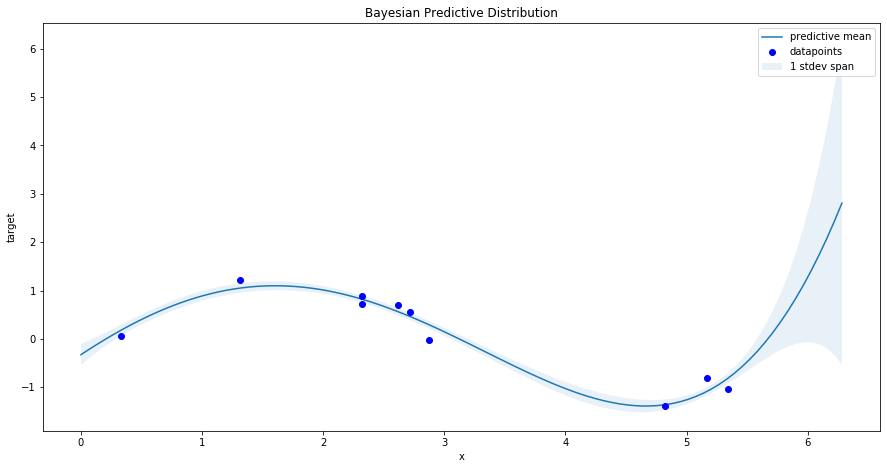

In [48]:
M = 4
alpha = 2/5
beta = 1/(0.25**2)

x, t = gen_sine2(10)
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

X = np.linspace(0, 2*pi, 100)
mean, sigma, Phi = predict_polynomial_bayes(X, m, S, beta)

plt.figure(figsize=[15,7.5], edgecolor='black')
plt.plot(X, mean, label='predictive mean')
plt.fill_between(X, mean+sigma, mean-sigma, alpha=0.1, label='1 stdev span')
plt.plot(x, t, 'bo', label='datapoints')
plt.legend()
plt.xlabel('x')
plt.ylabel('target')
plt.title('Bayesian Predictive Distribution')


b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


Text(0.5, 1.0, '4-th order polynomials with coefficients drawn from posterior distribution')

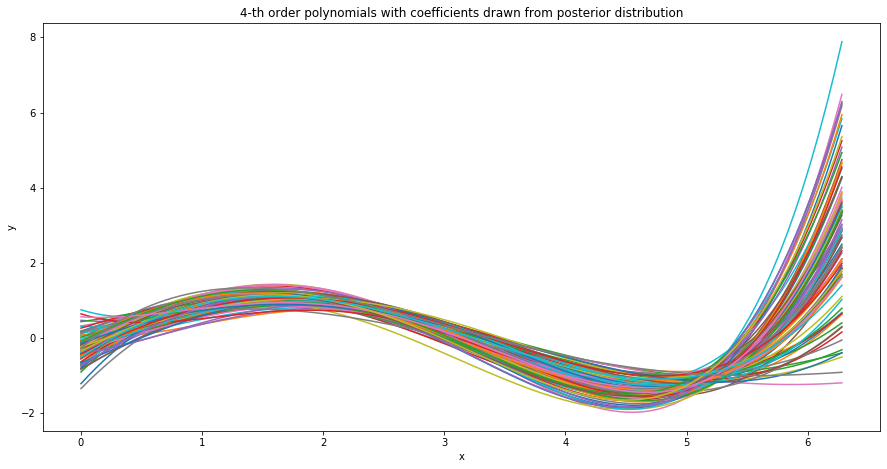

In [50]:
#Posterior distribution is normally distributed
w = np.random.multivariate_normal(m,S,100)
X = np.linspace(0, 2*pi, 100)

plt.figure(figsize=[15,7.5], edgecolor='black')

for i in range(w.shape[0]):
    beta = w[i,:]
    beta_f = np.flip(beta, 0) #np.poly1d takes the coefficients in decreasing power as input
    poly = np.poly1d(beta_f)
    y = poly(X)
    plt.plot(X,y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('4-th order polynomials with coefficients drawn from posterior distribution')
        


### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



When the sample becomes large (N $\rightarrow \infty$), the second term of the variance of the predictive distribution ($\phi(\bx)^T \bS_N \phi(\bx)$) goes to zero. The variance of the predictive distribution therefore consists solely of 1/$\beta$. When $\beta$=16, this results in a variance of 1/16 which means a standard deviation of 0.25. This is equal to the actual standard deviation of t, as given in (1.1).

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

The answer is given in Bishop, section 3.6: "The assumption that the basis functions are fixed before the training data set is observed and is a manifestation of the curse of dimensionality (section 1.4). As a consequence, the number of basis functions need to grow rapidly, often exponentially, with the dimensionality D of the input space."

An additional challenge lays in selecting the correct number (and type) of basis functions. We assume that the true dependency can be modelled by a linear combination of the bais functions and therefore need to find basis functions that can effectively model the true mapping. If to few basis functions (or unsuitable ones) are included, we model might not represent the true dependency. On the other hand, if too many basis functions are included, we can end up overfitting on the sample.



